In [17]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from imutils import paths
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import gc
import argparse
import random
import cv2
import os

In [2]:
#assign paths to files
traindir = "images/train"
validdir = "images/valid"
testdir = "images/test"


In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255)

In [5]:
#setup the generators for the batch learning method
batch_size = 10
train_generator = train_datagen.flow_from_directory(
        traindir,  # this is the target directory
        target_size=(768, 768),  
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = True,
        color_mode="rgb")  


valid_generator = train_datagen.flow_from_directory(
        validdir,
        target_size=(768, 768),
        batch_size=batch_size,
        color_mode="rgb",
        shuffle = True,
        class_mode='categorical')


test_generator = train_datagen.flow_from_directory(
        testdir,
        target_size=(768, 768),
        batch_size=1,
        shuffle = False,
        color_mode="rgb",
        class_mode='categorical')

Found 17500 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.


In [17]:
#the first model I tried as a test
model1 = Sequential()
inputShape = (768, 768, 3)

model1.add(Conv2D(32, (3, 3), padding="same",
            input_shape=inputShape))
model1.add(Activation("relu"))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.2))
model1.add(Conv2D(32, (3, 3), padding="same",input_shape=(250,250,3)))
model1.add(Activation("relu"))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.2))
model1.add(Dense(100))
model1.add(Dropout(0.5))
model1.add(Dense(100))
model1.add(Dropout(0.5))

# softmax classifier
model1.add(Flatten())
model1.add(Dense(5))
model1.add(Activation("softmax"))

In [18]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 500, 500, 32)      896       
_________________________________________________________________
activation_9 (Activation)    (None, 500, 500, 32)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 500, 500, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 250, 250, 32)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 250, 250, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 250, 250, 32)      9248      
_________________________________________________________________
activation_10 (Activation)   (None, 250, 250, 32)     

In [19]:
opt = Adam(learning_rate=0.01)
model1.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

In [20]:

n_epochs = 15
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model1.fit(train_generator, epochs=n_epochs, steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID)

Epoch 1/15
546/546 [==============================] - 335s 613ms/step - loss: 82.3496 - accuracy: 0.7151 - val_loss: 51.8681 - val_accuracy: 0.5445
Epoch 2/15
546/546 [==============================] - 317s 580ms/step - loss: 19.3206 - accuracy: 0.7533 - val_loss: 29.1946 - val_accuracy: 0.6002
Epoch 3/15
546/546 [==============================] - 311s 570ms/step - loss: 4.6692 - accuracy: 0.7885 - val_loss: 8.3390 - val_accuracy: 0.7302
Epoch 4/15
546/546 [==============================] - 314s 575ms/step - loss: 3.1881 - accuracy: 0.7982 - val_loss: 5.8848 - val_accuracy: 0.7212
Epoch 5/15
546/546 [==============================] - 315s 577ms/step - loss: 5.2365 - accuracy: 0.8009 - val_loss: 653.2150 - val_accuracy: 0.2470
Epoch 6/15
546/546 [==============================] - 313s 573ms/step - loss: 637.6768 - accuracy: 0.7082 - val_loss: 81.1836 - val_accuracy: 0.7244
Epoch 7/15
546/546 [==============================] - 311s 570ms/step - loss: 36.5667 - accuracy: 0.7831 - val_loss

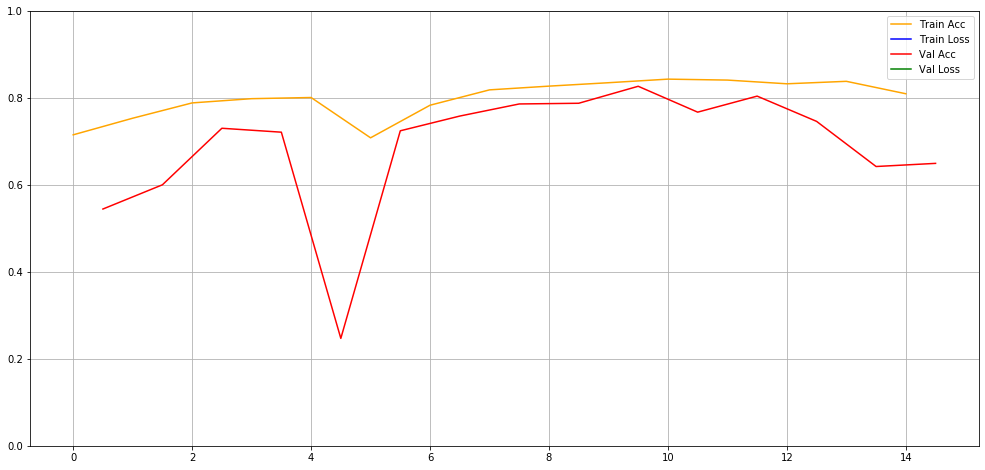

In [24]:
plt.figure(figsize=(17,8))
plt.plot(np.arange(0,n_epochs),history.history['accuracy'], color='orange')
plt.plot(np.arange(0,n_epochs),history.history['loss'],'b')
plt.plot(np.arange(0,n_epochs)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
plt.plot(np.arange(0,n_epochs)+0.5,history.history['val_loss'],'g')
plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
plt.show() 

The final model I chose to work with

Model 2 Architecture
INPUT => [CONV => RELU =>BN] * 2 => POOL => DO => [CONV => RELU =>BN]* 2 => POOL => DO =>
[CONV => RELU => BN]  * 3 => POOL => DO => [CONV => RELU =?BN] * 3 => POOL =>DO =>
[FC => RELU => DO] * 2 => SOFTMAX

In [6]:
model2 = Sequential()
inputShape = (768,768, 3)

model2.add(Conv2D(32, (3, 3), padding="same",
            input_shape=inputShape))
model2.add(Activation("relu"))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3), padding="same"))
model2.add(Activation("relu"))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(32, (3, 3), padding="same"))
model2.add(Activation("relu"))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3), padding="same"))
model2.add(Activation("relu"))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(32, (3, 3), padding="same"))
model2.add(Activation("relu"))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3), padding="same"))
model2.add(Activation("relu"))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3), padding="same"))
model2.add(Activation("relu"))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(32, (3, 3), padding="same"))
model2.add(Activation("relu"))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3), padding="same"))
model2.add(Activation("relu"))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3), padding="same"))
model2.add(Activation("relu"))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.2))


model2.add(Dense(100))
model2.add(Activation("relu"))
model2.add(Dropout(0.5))
model2.add(Dense(100))
model2.add(Activation("relu"))
model2.add(Dropout(0.5))

# softmax classifier
model2.add(Flatten())
model2.add(Dense(5))
model2.add(Activation("softmax"))

In [7]:
#setup a function to use with a learning rate decay callback - this didn't work with the batch learning technique
def step_decay(epoch):
# initialize the base initial learning rate, drop factor, and
# epochs to drop every
    initAlpha = 0.01
    factor = 0.25
    dropEvery = 5

# compute learning rate for the current epoch
    alpha = initAlpha * (factor ** np.floor((1 + epoch) / dropEvery))

# return the learning rate
    return float(alpha)

In [27]:
opt = Adam(learning_rate=0.01, decay=0.01/batch_size)
model2.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])


n_epochs = 50
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history2 = model2.fit(train_generator, epochs=n_epochs, steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID)
model.save("model2")

Epoch 1/50
1750/1750 [==============================] - 804s 459ms/step - loss: 1.2457 - accuracy: 0.5597 - val_loss: 0.8889 - val_accuracy: 0.5590
Epoch 2/50
1750/1750 [==============================] - 801s 458ms/step - loss: 0.7401 - accuracy: 0.6160 - val_loss: 0.6420 - val_accuracy: 0.6802
Epoch 3/50
1750/1750 [==============================] - 802s 458ms/step - loss: 0.5961 - accuracy: 0.6972 - val_loss: 0.6315 - val_accuracy: 0.6524
Epoch 4/50
1750/1750 [==============================] - 802s 458ms/step - loss: 0.5519 - accuracy: 0.7361 - val_loss: 0.4819 - val_accuracy: 0.7568
Epoch 5/50
1750/1750 [==============================] - 802s 458ms/step - loss: 0.4922 - accuracy: 0.7689 - val_loss: 0.4507 - val_accuracy: 0.7894
Epoch 6/50
1750/1750 [==============================] - 802s 458ms/step - loss: 0.4507 - accuracy: 0.7914 - val_loss: 0.4022 - val_accuracy: 0.8124
Epoch 7/50
1750/1750 [==============================] - 804s 459ms/step - loss: 0.4148 - accuracy: 0.8097 - val_

NameError: name 'model' is not defined

In [28]:
model2.save("model2")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model2\assets


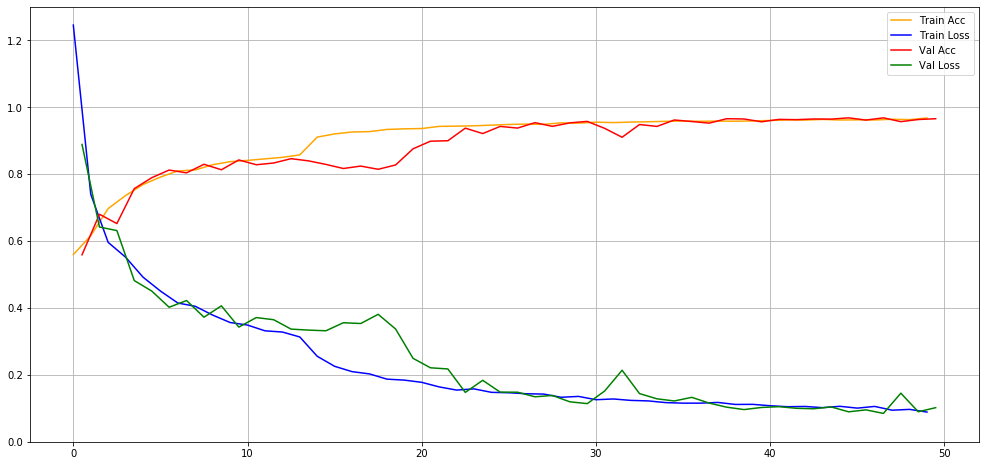

In [30]:
plt.figure(figsize=(17,8))
plt.plot(np.arange(0,n_epochs),history2.history['accuracy'], color='orange')
plt.plot(np.arange(0,n_epochs),history2.history['loss'],'b')
plt.plot(np.arange(0,n_epochs)+0.5,history2.history['val_accuracy'],'r')  # offset both validation curves
plt.plot(np.arange(0,n_epochs)+0.5,history2.history['val_loss'],'g')
plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
plt.grid(True)
plt.gca().set_ylim(0, 1.3) # set the vertical range to [0-1] 
plt.show() 

In [36]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 768, 768, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 768, 768, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768, 768, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 768, 768, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 768, 768, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 768, 768, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 384, 384, 32)      0

In [32]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

predictions = model2.predict(test_generator, steps = STEP_SIZE_TEST)

In [34]:
target_names = []

for key in test_generator.class_indices:

    target_names.append(key)

In [35]:
print(classification_report(test_generator.classes,
 predictions.argmax(axis=1),target_names=target_names))

                              precision    recall  f1-score   support

        Colon_adenocarcinoma       1.00      0.98      0.99       500
                Colon_benign       0.98      1.00      0.99       500
Lung squamous_cell_carcinoma       0.97      0.92      0.94       500
         Lung_adenocarcinoma       0.91      0.97      0.94       500
                 Lung_benign       1.00      0.98      0.99       500

                    accuracy                           0.97      2500
                   macro avg       0.97      0.97      0.97      2500
                weighted avg       0.97      0.97      0.97      2500

